In [1]:
import pandas as pd
import seaborn as sns
from utils.text import plot_wordclouds

In [2]:
binary=False
lowercase=True

# Carregando dados de análise

In [3]:
data_df = pd.read_csv("/home/kenzosaki/mestrado/data/tweetsentbr/tweetsentbr_test.csv", index_col=0)

In [4]:
id2label = {
    0: "neutro",
    1: "positivo",
    2: "negativo"
}

In [5]:
# Convertendo ids para labels para facilitar interpretação
data_df["label"] = data_df["label"].map(id2label)

In [6]:
data_df.head()

,label,text
2403,positivo,Começou o The Noite com o Charlie Hunnam
1349,negativo,"No twitter a 3ª feira é chata,pois todo mundo ..."
5422,neutro,Bial declamando os do garçom Conversa Com Bial
1262,neutro,AI MEU DEUS É AGORA Master Chef BR
5438,negativo,A Miriam só não roda pq eu acho que o tal sorv...


In [7]:
# Para focar a análise em apenas duas classes: positio e neutro
if binary:
    data_df = data_df[data_df["label"] != "neutro"]

if lowercase:
    data_df["text"] = data_df["text"].apply(lambda x: x.lower())

# Carregando Sentence-Bert

Sentence-Bert treinado a partir do Bertimbau e ajustado no ASSIN2.

In [8]:
from sentence_transformers import SentenceTransformer

In [9]:
model = SentenceTransformer("/home/kenzosaki/mestrado/data/models/similarity_bertimbau", device="cuda")

# Conversão dos textos para representações densas

Sentence-Bert converte textos para vetores densos de 768 dimensões.

In [10]:
from sklearn.preprocessing import normalize

In [11]:
text_vectors = model.encode(data_df["text"].values, show_progress_bar=True)

In [12]:
text_vectors.shape

(2463, 768)

In [13]:
# Normalização L2 para geração de vetores unitários
text_vectors = normalize(text_vectors)

# Agrupamento usando K-means

In [14]:
from sklearn.cluster import KMeans
from tqdm import tqdm

In [15]:
# Quantidades de clusters para avaliar
n_clusters = list(range(2,11))
n_clusters

[2, 3, 4, 5, 6, 7, 8, 9, 10]

In [16]:
fitted_models = []
for k in tqdm(n_clusters):
    
    kmeans = KMeans(n_clusters=k, n_init=100, init='random', max_iter=500)
    kmeans.fit(text_vectors)

    fitted_models.append(kmeans)

100%|██████████| 9/9 [00:29<00:00,  3.30s/it]


# Avaliando silhueta dos agrupamentos gerados

In [17]:
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster.silhouette import silhouette_visualizer
import numpy as np
import matplotlib.pyplot as plt

In [18]:
%matplotlib inline

In [19]:
sns.set(rc={'figure.figsize':(15,6)})

In [20]:
silhouettes = [silhouette_score(text_vectors, kmeans.labels_) for kmeans in fitted_models]
inertias = [kmeans.inertia_ for kmeans in fitted_models]

Text(0.5, 0, 'Number of clusters')

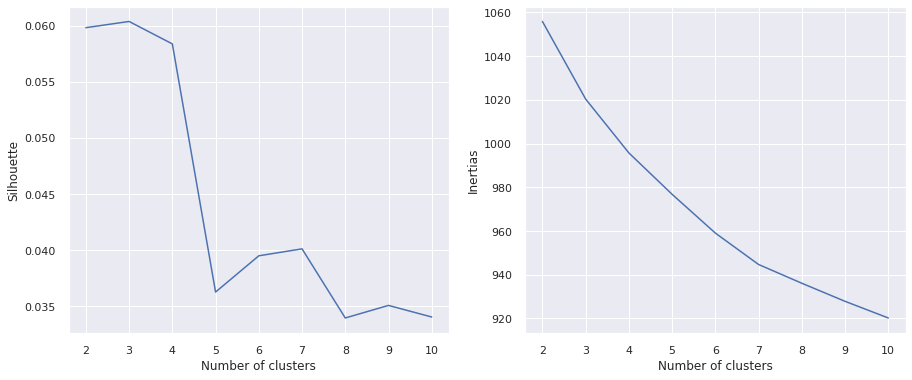

In [21]:
fig, axes = plt.subplots(1,2)

ax = sns.lineplot(x=n_clusters, y=silhouettes, ax=axes[0])
ax.set_ylabel("Silhouette")
ax.set_xlabel("Number of clusters")

ax = sns.lineplot(x=n_clusters, y=inertias, ax=axes[1])
ax.set_ylabel("Inertias")
ax.set_xlabel("Number of clusters")

In [22]:
# Escolhendo o modelo de maior silhueta mpedia para análise
kmeans = fitted_models[np.argmax(silhouettes)]
# kmeans = fitted_models[3]

In [23]:
data_df["silhouette"] = silhouette_samples(text_vectors, kmeans.labels_)
data_df["cluster"] = kmeans.labels_

In [24]:
mean_silh = data_df["silhouette"].mean()

In [25]:
print(f"- EE: {kmeans.inertia_}")
print(f"- Mean silhouette: {mean_silh}")

- EE: 1020.357666015625
- Mean silhouette: 0.06036132946610451


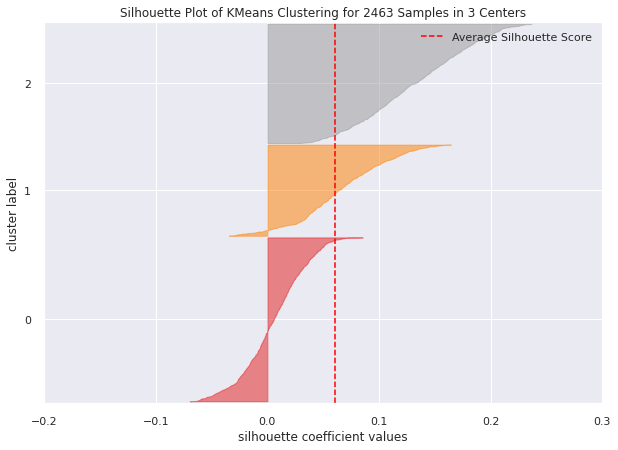

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f0e60ff7590>,
                     estimator=KMeans(init='random', max_iter=500, n_clusters=3,
                                      n_init=100))

In [26]:
sns.set(rc={'figure.figsize':(10,7)})
silhouette_visualizer(
    kmeans,
    X=text_vectors,
    y=data_df["label"].values,
    is_fitted=True
)

# Comparação entre clusters

Comparando pares de clusters, com relação as classes (positivo, neutro ou negativo) e palavras frequentes.

In [39]:
cluster_pair = (1, 2)

In [40]:
c0_df = data_df[data_df["cluster"] == cluster_pair[0]]
c1_df = data_df[data_df["cluster"] == cluster_pair[1]]

## Distribuição de classes por cluster

In [41]:
order = ["positivo", "negativo"] if binary else \
        ["positivo", "neutro", "negativo"]

Text(0.5, 0, 'Cluster 2')

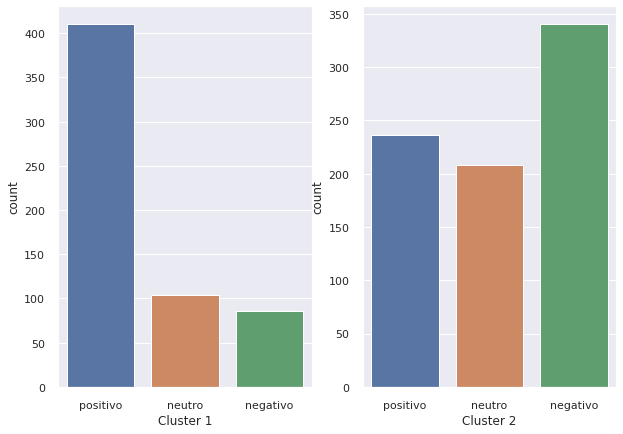

In [42]:
fig, axes = plt.subplots(1,2)

c0_df = data_df[data_df["cluster"] == cluster_pair[0]]
c1_df = data_df[data_df["cluster"] == cluster_pair[1]]

sns.countplot(data=c0_df, x="label", ax=axes[0], order=order)
axes[0].set_xlabel(f"Cluster {cluster_pair[0]}")
sns.countplot(data=c1_df, x="label", ax=axes[1], order=order)
axes[1].set_xlabel(f"Cluster {cluster_pair[1]}")

## Wordclouds por cluster

Gerando nuvens de palavras para cluster do par em análise.

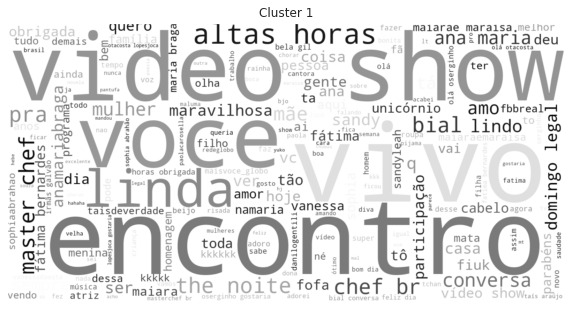

In [43]:
plot_wordclouds(
    text=" ".join(c0_df["text"].values.tolist()),
    title=f"Cluster {cluster_pair[0]}",
    colormap="binary", 
    background_color='white',
    max_words=200,
    width=1600, height=800
)

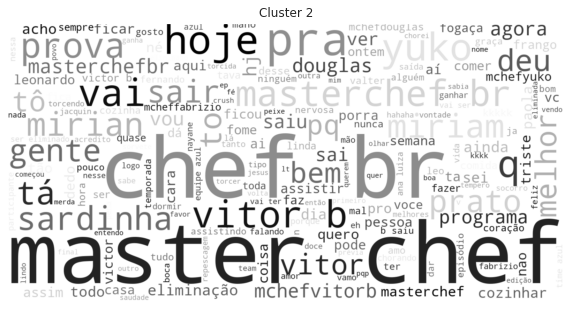

In [44]:
plot_wordclouds(
    text=" ".join(c1_df["text"].values.tolist()),
    title=f"Cluster {cluster_pair[1]}",
    colormap="binary", 
    background_color='white',
    max_words=200,
    width=1600, height=800
)

# Visualizando exemplos de maior silhueta por cluster

In [45]:
cluster = 1
c_df = data_df[data_df["cluster"] == cluster]

In [46]:
pd.set_option('max_colwidth', None)
c_df.sort_values(by="silhouette", ascending=False).head(10)

,label,text,silhouette,cluster
3115,positivo,"eu sou apaixonada pela taís araújo, que mulher maravilhosa. mais voce",0.164312,1
328,positivo,a lua blanco é maravilhosa dms né !? que mulher linda ! encontro @lua_blanco,0.159505,1
1707,positivo,"estou apaixonada pela cora, que menina maravilhosa! carolina casting está de parabéns. encontro",0.158414,1
5923,positivo,minha princesa mais linda !! está maravilhosa @fbbreal ❤❤ video show ao vivo,0.157978,1
9404,positivo,video show ao vivo a bruna é muito linda!! e sophia vc esta linda e alternativa! bjs,0.156032,1
414,positivo,mais você. que mulher linda! @taisdeverdade é um encanto! tão bom vê-la ! bom diaa!!!,0.153857,1
5659,positivo,lais souza é muito linda gente 😍😍😍 altas horas,0.153077,1
7374,positivo,sandy sempre maravilhosa ❤ encontro,0.152048,1
9414,positivo,"monica linda,maravilhosa, deusaaaaa video show ao vivo",0.150946,1
6839,positivo,sophia está lindinha. video show ao vivo,0.150404,1


# Análise PCA

Gerando representações PCA com 2 componentes principais para realizar plots em duas dimensões.

In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [48]:
scaler = StandardScaler()
std_vectors = scaler.fit_transform(text_vectors)

In [49]:
pca = PCA(n_components=2)
pca_representations = pca.fit_transform(std_vectors)

In [50]:
print(f"Usar 2 componentes principais preserva {pca.explained_variance_ratio_.sum() * 100}% da variância dos dados.")

Usar 2 componentes principais preserva 12.979903817176819% da variância dos dados.


## Visualizando as representações em duas dimensões

A partir das representações geradas pelo Sentence-Bert, utilizamos PCA para extrair 2 componentes principais para plot 2D. Em seguida, as imagens abaixo mostram como os clusters e as classes (positivo, neutro e nagtivo) estão distribuídas utilizando 2 componentes.

Text(0.5, 1.0, 'Labels')

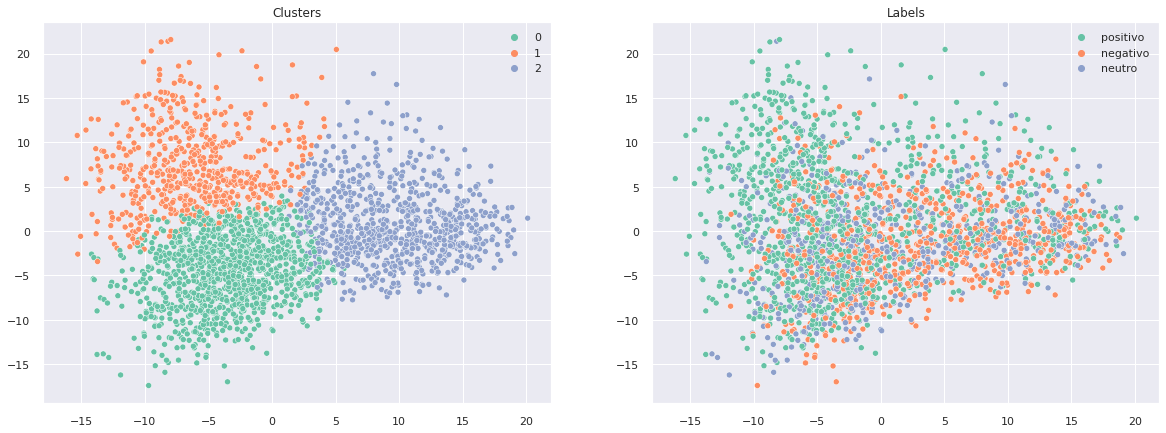

In [54]:
sns.set(rc={'figure.figsize':(20,7)})

fig, axes = plt.subplots(1,2)

sns.scatterplot(x=pca_representations[:, 0], y=pca_representations[:, 1], hue=data_df["cluster"].values, palette="Set2", ax=axes[0])
axes[0].set_title("Clusters")

sns.scatterplot(x=pca_representations[:, 0], y=pca_representations[:, 1], hue=data_df["label"].values, palette="Set2", ax=axes[1])
axes[1].set_title("Labels")